In [8]:
import itertools

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from matplotlib import colors


def generate_perturbation_scheme(enz_names, perturbation_range):  # also here make sure
    """Given the perturbation profile,create a dictionary
    Input:
    perturbation_range: perturbation value of vmax w.r.t. wildtype
    ndim: the number of fluxes to consider

    Output of dictionaries
    """
    ndim = len(enz_names)
    dim_range_list = []
    for i in range(ndim):
        dim_range_list.append(np.array(perturbation_range))
    # Cartesian product
    cart = []
    for element in itertools.product(*dim_range_list):
        cart.append(element)
    design_list = []
    for i in range(len(cart)):
        values = tuple(cart[i])
        design = dict(zip(enz_names, values))
        design_list.append(design)
    return design_list, cart


def scenario1(perturb_range, N, enz_names):
    cart = []
    designs_list = []
    for i in range(N):
        x = np.random.choice(perturb_range, len(enz_names))
        x = tuple(x)
        cart.append(x)
    for i in range(len(cart)):
        design = dict(zip(enz_names, cart[i]))
        designs_list.append(design)
    return designs_list, cart


def find_set_designs(comb_space, tcart, enz_names):
    """finds the training or test set designs in the combinatorial space
    Number of features has to be given
    - combinatorial space
    - cart of either the training scenario or the test set
    - enzyme names"""
    tset = pd.DataFrame()
    for design in tcart:
        sub = comb_space
        sub = sub.loc[sub["vmax_forward_Enzyme_A"] == design[0]]
        sub = sub.loc[sub["vmax_forward_Enzyme_B"] == design[1]]
        sub = sub.loc[sub["vmax_forward_Enzyme_C"] == design[2]]
        sub = sub.loc[sub["vmax_forward_Enzyme_D"] == design[3]]
        sub = sub.loc[sub["vmax_forward_Enzyme_E"] == design[4]]
        sub = sub.loc[sub["vmax_forward_Enzyme_F"] == design[5]]
        sub = sub.loc[sub["vmax_forward_Enzyme_G"] == design[6]]
        tset = pd.concat([tset, sub])
    return tset, tcart

In [9]:
url = "https://media.githubusercontent.com/media/AbeelLab/simulated-dbtl/main/data/combinatorial_space/combinatorial_space_pathway_A.csv"
r = requests.get(url)

with open("combinatorial_space_pathway_A.csv", "wb") as f:
    f.write(r.content)

comb_space = pd.read_csv("combinatorial_space_pathway_A.csv")

# enzyme names and perturbation range
enz_names = [
    "vmax_forward_Enzyme_A",
    "vmax_forward_Enzyme_B",
    "vmax_forward_Enzyme_C",
    "vmax_forward_Enzyme_D",
    "vmax_forward_Enzyme_E",
    "vmax_forward_Enzyme_F",
    "vmax_forward_Enzyme_G",
]  #'vmax_forward_LDH_D',
perturb_range = [0.25, 0.5, 1, 1.5, 2, 4]
designs, cart = generate_perturbation_scheme(enz_names, perturb_range)

In [17]:
sc1_designs, sc1_cart = scenario1(perturb_range, 50, enz_names)
training_scenario1, training_cart = find_set_designs(comb_space, sc1_cart, enz_names)
train_X = training_scenario1[enz_names]
train_y = training_scenario1["Enzyme_G"]
test_X = comb_space[enz_names]
test_Y = comb_space["Enzyme_G"]

print(f"Number of training samples: {len(train_X)}")
print(f"Number of test samples: {len(test_X)}")

Number of training samples: 50
Number of test samples: 279936


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

lr = LinearRegression(fit_intercept=True)
lr.fit(train_X_scaled, train_y)

r2 = lr.score(train_X_scaled, train_y)
print(f"R2: {r2}")


R2: 0.3688141920443452


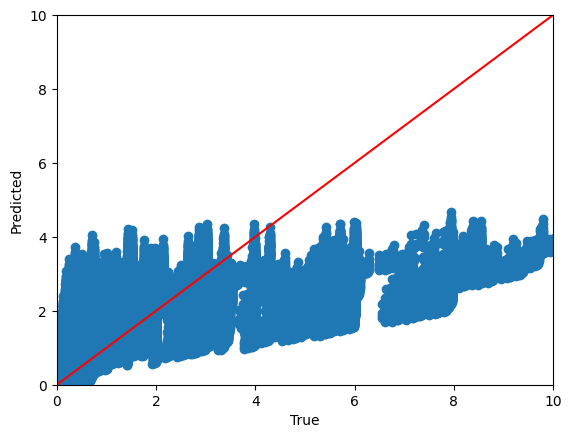

In [27]:
y_pred = lr.predict(test_X_scaled)

fig, ax = plt.subplots()
ax.scatter(test_Y, y_pred)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="red")
